> 이 문서의 폰트크기는 브라우저 인쇄시 인쇄 배율 75%로 최적화 되어 있음


# 예제 1. MNIST  분류 : CNN (일반)

> <학습 목표>    
> - 파이토치 모듈 API 기반 직렬 결합 방식의 CNN 모델의 일반적인 제작 기법 이해

> < 코드 구성>   
> 1. 학습 데이터 구축   
>    (1) 학습테이터의 첫번째 이미지의 확인하기 
>    (2) 학습 데이터의 첫 100개 이미지 보기
> 2. 데이터셋 및 데이터로더 객체 생성   
> 3. CNN 모델 클래스 및 모델 성능 측정 함수 정의   
>    (1) CNN 모델 클래스   
>     (2) 학습된 모델의 추론 및 정확도 산출 함수   
> 4. 훈련된 모델 사용하기   
>     (1) 한 개의 입력 이미지 분류 하기   
>     (2) 검증용(테스트) 이미지 각각을 분류하여 잘못 분류된 이미지들 보기
>     (3) 훈련용 이미지 각각을 분류하여 잘못 분류된 이미지들 보기

In [30]:
# multi line 출력을 위한 셀 -- 필요시 주석해제 후 이 셀을 실행시키기 바람
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [31]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)

from torchvision.datasets import MNIST
from torchvision import transforms
import tqdm

## 1. 학습 데이터셋 구축


In [32]:
##### 입력 샘플과  X와 목표치 D
mnist_train = MNIST("./data",
                        train=True, download=True,
                        transform=transforms.ToTensor())

# 시험용  데이터 가져오기
mnist_test = MNIST("./data",
                    train=False, download=True,
                    transform=transforms.ToTensor())

def data_info():
    print(len(mnist_train))
    print(len(mnist_test))
    print(mnist_train.classes)
    print(mnist_train.class_to_idx)

data_info()

60000
10000
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


### (1) 학습데이터의 첫번째 이미지의 확인하기

label = 5


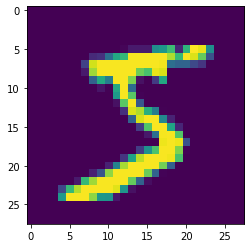

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

In [33]:
img, label = mnist_train[0]
print("label =", label)
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(img.size())
print(img)

### (2) 학습 데이터의 첫 100개 이미지 보기

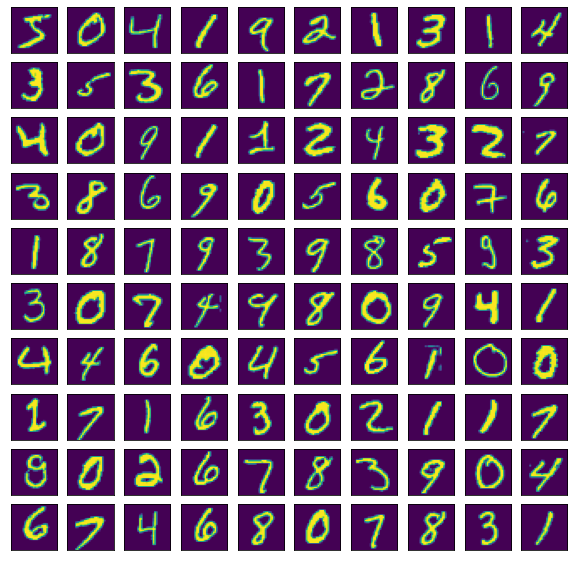

In [34]:
class_names = ['0', '1','2', '3', '4', '5', '6', '7', '8', '9']

fig = plt.figure(figsize=(10, 10))
i = 0
for img, label in mnist_train:
    ax = fig.add_subplot(10, 10, 1 + i, xticks=[], yticks=[])
    i = i + 1
    plt.imshow(img.permute(1, 2, 0))
    if i == 100:
        break     

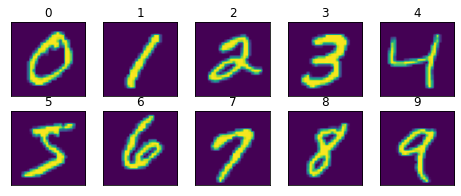

In [35]:
# 각 클래스별 첫번째 이미지 디스플레이 하기
class_names = ['0', '1','2', '3', '4', '5', '6', '7', '8', '9']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in mnist_train if label == i)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

## 2. 데이터로더 객체 생성
- GPU 실행을 위한 데이터 변환 내용도 들어 있으며, 필요시 주석해제 후 GPU 기반 실행 실습 요망

In [36]:
# 배치 크기가 128인 DataLoader를 각각 작성
batch_size=128
train_loader = DataLoader(mnist_train, 
                          batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(mnist_test,
                          batch_size=batch_size, shuffle=False)

## 3. CNN 모델 클래스 및 모델 성능 측정 함수 정의 

### (1) CNN 모델 클래스

In [37]:
## (N, C, H, W) Tensor를 (N, C*H*W)로 변형 계층 (합성곱 출력을 MLP에 전달할 때 사용)
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
 
        return x.view(sizes[0], -1)

## 2개의 컨볼루션 계층
    # conv1 : 1채널 입력, 32개 5×5 필터, conv2 : 32채널 입력, 64개 5×5 필터
    # Batch Normalization과 Dropout 적용
## 2개의 FC 채널
    # fc1은 Batch Normalization과 Dropout 적용
## 활성화함수는 최종 출력 계층만 제외하고 relu()를 사용

conv_net = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size= 5),  #  32 x 24 x 24
    nn.MaxPool2d(2),                   #  32 x 12 x 12
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    
    nn.Conv2d(32, 64, kernel_size= 5),  #  64 x 8 x 8
    nn.MaxPool2d(2),                    #  64 x 4 x 4
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    
    FlattenLayer()
)

# 위 합성곱 계층들에 의한 최종이미지 크기 추출
test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]

# 2 계층 MLP
fnn = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)
# 최종 CNN
model = nn.Sequential(
    conv_net,
    fnn
)

# ADAMS의 optimizer 생성
optimizer = optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# 크로스 엔트로피 오차 함수 생성
loss_fn = nn.CrossEntropyLoss()

### (2) 학습된 모델의 추론 및 정확도 산출 함수

In [38]:
# 추론 및 정확도 산출
def eval_model(model, data_loader, device="cpu"):
    # Dropout 및 BatchNorm을 무효화
    model.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        # to 메서드로 계산을 실행할 디바이스로 전송
        x = x.to(device)
        y = y.to(device)
        # 확률이 가장 큰 클래스를 예측(리스트 2.1 참조)
        # 여기선 forward（추론） 계산이 전부이므로 자동 미분에
        # 필요한 처리는 off로 설정해서 불필요한 계산을 제거
        with torch.no_grad():
            _, y_pred = model(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)

    # 미니 배치 단위의 예측 결과 등을 하나로 묶는다
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 예측 정확도 계산
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

## 3. CNN 훈련 
### (1) CNN 훈련 시키기
- 시간 상 4 에포크 분량 훈련 / cpu 환경

In [39]:
# 신경망의 모든 파라미터
device = "cpu"
#device = "cuda:0"

model.to(device)

# 훈련 실행
EPOCHS = 4

log_train_loss = []
log_train_acc = []
log_valid_acc = []

#opt = optimizer(model.parameters())

for epoch in range(EPOCHS):
    epoch_loss = 0.0
    # 신경망을 훈련 모드로 설정
    model.train()
    n = 0
    acc = 0
    i = 0
    # 시간이 많이 걸리므로 tqdm을 사용해서 진행바를 표시
    for i, (x_mb, d_mb) in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
        x_mb = x_mb.to(device)
        d_mb = d_mb.to(device)
        h = model(x_mb)
        loss = loss_fn(h, d_mb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n += len(x_mb)
        _, y_pred = h.max(1)
        acc += (d_mb == y_pred).sum().item()

    log_train_loss.append(epoch_loss / i)
    # 훈련 데이터의 예측 정확도
    log_train_acc.append(acc / n)

    # 검증 데이터의 예측 정확도
    log_valid_acc.append(eval_model(model, valid_loader, device))
    # epoch의 결과 표시
    print(epoch, log_train_loss[-1], log_train_acc[-1], log_valid_acc[-1], flush=True)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:19<00:00, 23.66it/s]


0 0.13724245017187464 0.9604166666666667 0.989300012588501


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 23.31it/s]


1 0.05517764107929145 0.9833833333333334 0.9897000193595886


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 23.11it/s]


2 0.040695817208785214 0.98735 0.9901999831199646


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:20<00:00, 23.14it/s]


3 0.035393321569750294 0.98885 0.9923999905586243


### (2) 최종 오차/정확도 출력 및 에포크별 오차/정확도 그래프 디스플레이 하기

최종 Training Accuracy = 0.9889   최종 Validation Accuracy = 0.9924


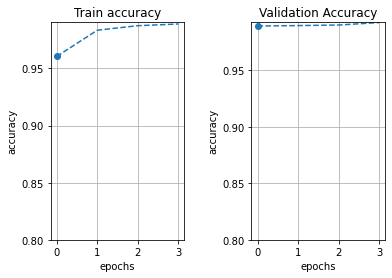

In [40]:
print("최종 Training Accuracy = %1.4f" % log_train_acc[-1], end='   ')
print("최종 Validation Accuracy = %1.4f" % log_valid_acc[-1])

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), log_train_acc, 'o--', markevery=10)
plt.title("Train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xticks(range(0, EPOCHS, 1))
plt.yticks(np.arange(0.8, 1, 0.05))
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS),log_valid_acc, 'o--', markevery=10)
plt.title("Validation Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xticks(range(0, EPOCHS, 1))
plt.yticks(np.arange(0.8, 1, 0.05))
plt.grid()

plt.subplots_adjust(wspace=0.5)
plt.show()

## 4. 훈련된 모델 사용하기
### (1) 한 개의 입력 이미지 분류 하기

torch.Size([1, 28, 28])
label = 8
torch.Size([1, 1, 28, 28])
예측 = 8
정확하게 분류하였읍니다.


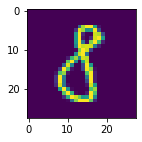

In [41]:
TEST_IMAGE_INDEX = 1200
img, label = mnist_test[TEST_IMAGE_INDEX]
print(img.size())
fig = plt.figure(figsize=(3,2))
plt.imshow(img.permute(1, 2, 0))
print("label =", label)

img = torch.unsqueeze(img, 0)  # 4 
print(img.size())
_, y_pred = model(img).max(1)
print("예측 =", y_pred.item())
if label == y_pred.item():
    print("정확하게 분류하였읍니다.")
else:
    print("분류를 제대로 하지 못했읍니다.")

### (2) 테스트 이미지 각각을 분류하여 잘못 분류된 이미지들 보기

분류 실패 이미지 개수 = 76


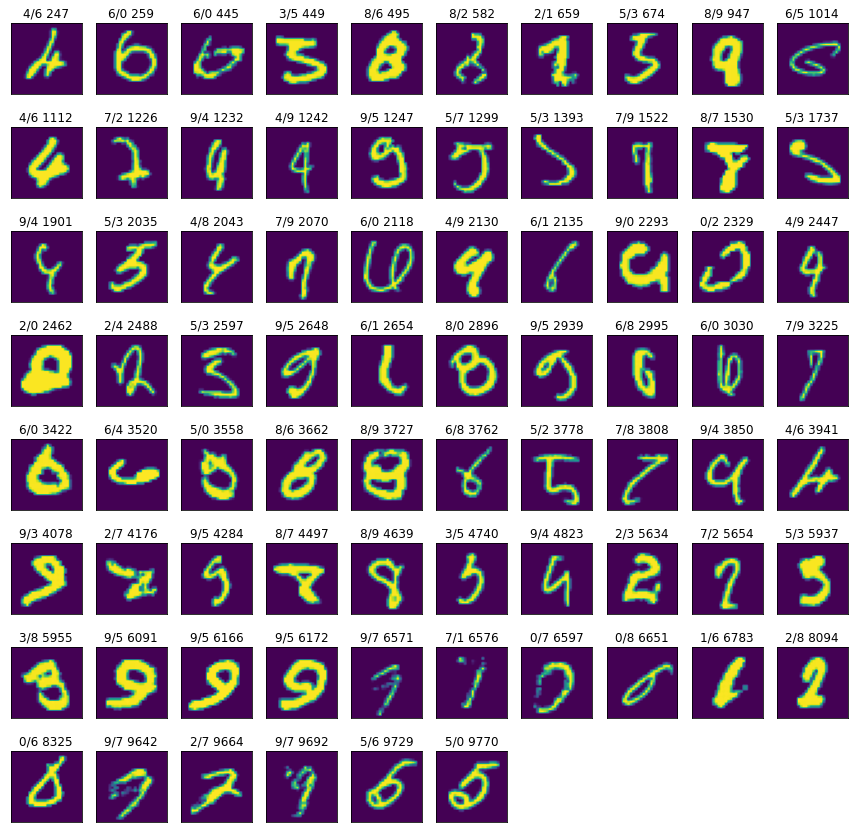

In [42]:
fail_list = []
fail_pred = []

i = 0
failures = 0
for img, label in mnist_test:
    img_org = img
    img = torch.unsqueeze(img, 0)  
    _, y_pred = model(img).max(1)
    if label == y_pred.item():
        i += 1
        continue
        
    failures +=1
    fail_list.append(i)
    fail_pred.append(y_pred.item())
    #print("%d, label=%d prediction=%d" % (i, label, y_pred.item()))
    i += 1

print("분류 실패 이미지 개수 = %d" % failures)
#print(fail_list)
#print(fail_pred)

row = failures // 10
if failures % 10 != 0:
    row += 1

fig = plt.figure(figsize=(15,15))

j = 0
for i in fail_list:
    img, label = mnist_test[i]
    ax = fig.add_subplot(row, 10, 1 + j, xticks=[], yticks=[])
    ax.set_title("{}/{} {}".format(label,fail_pred[j], i))  # label/prediction index
    plt.imshow(img.permute(1, 2, 0))
    j += 1
plt.show()

### (2) 훈련 이미지 각각을 분류하여 잘못 분류된 이미지들 보기

분류 실패 이미지 개수 = 220


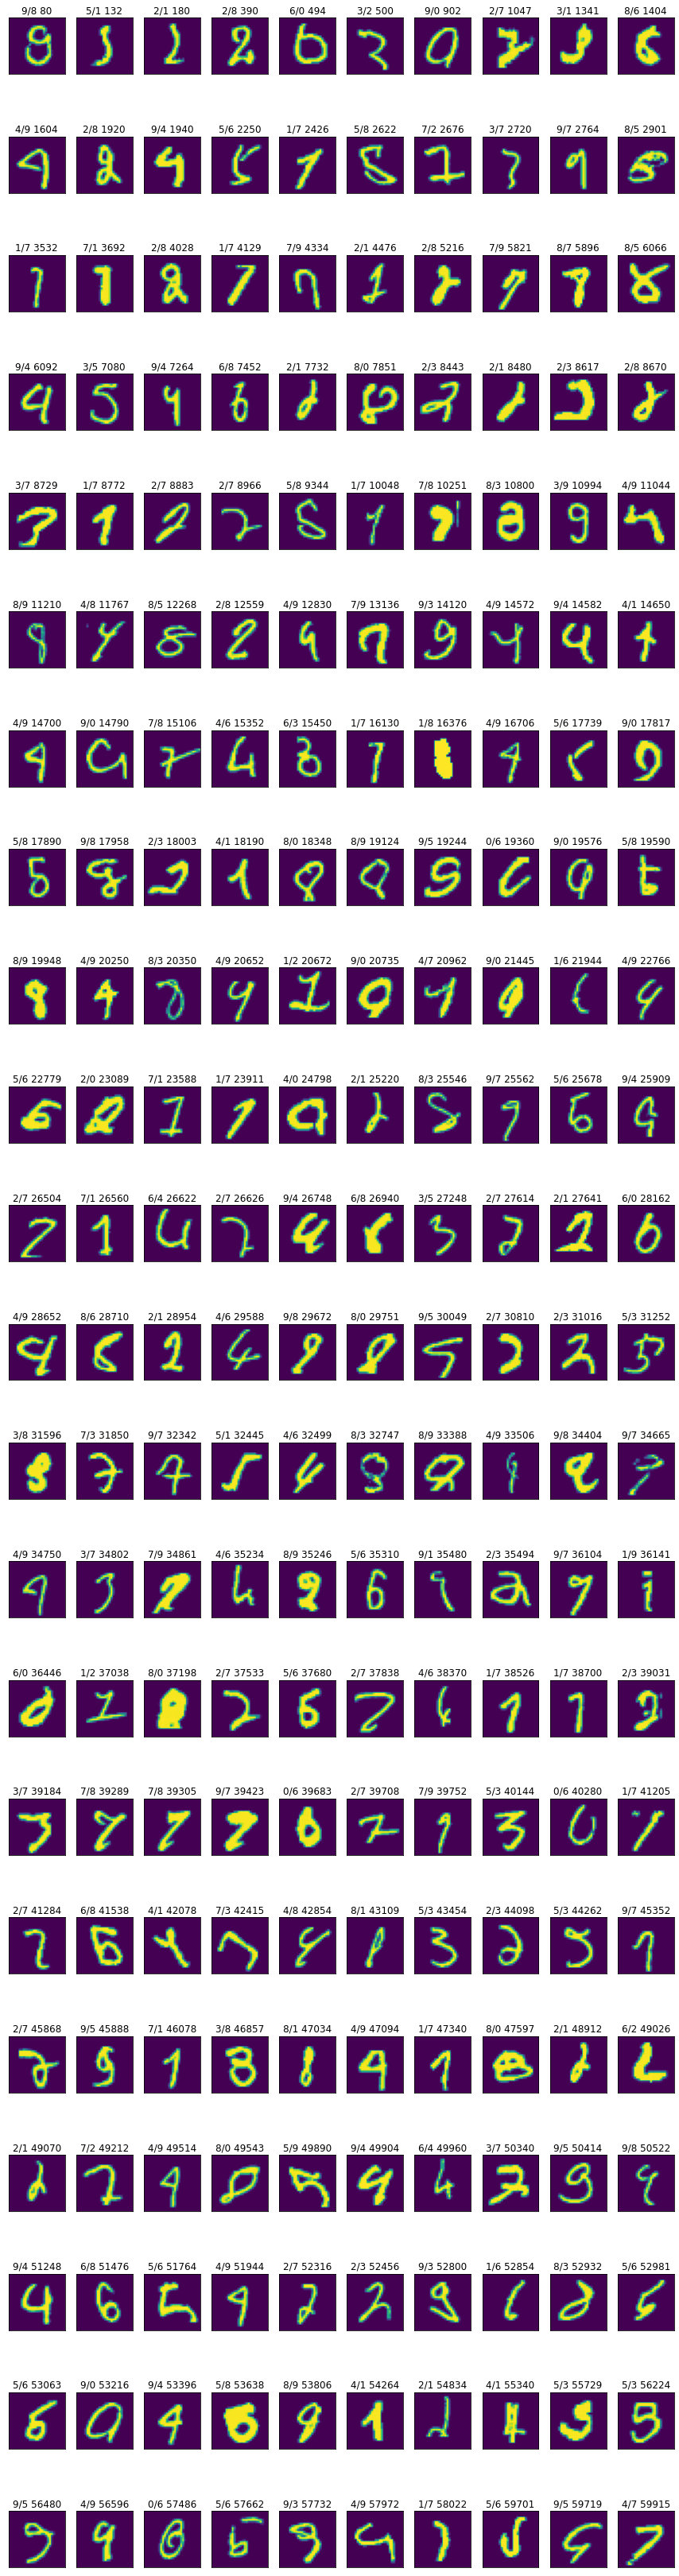

In [43]:
fail_list = []
fail_pred = []

i = 0
failures = 0
for img, label in mnist_train:
    img_org = img
    img = torch.unsqueeze(img, 0)  
    _, y_pred = model(img).max(1)
    if label == y_pred.item():
        i += 1
        continue
        
    failures +=1
    fail_list.append(i)
    fail_pred.append(y_pred.item())
    #print("%d, label=%d prediction=%d" % (i, label, y_pred.item()))
    i += 1

print("분류 실패 이미지 개수 = %d" % failures)
#print(fail_list)
#print(fail_pred)

row = failures // 10
if failures % 10 != 0:
    row += 1

fig = plt.figure(figsize=(15,60))

j = 0
for i in fail_list:
    img, label = mnist_train[i]
    ax = fig.add_subplot(row, 10, 1 + j, xticks=[], yticks=[])
    ax.set_title("{}/{} {}".format(label,fail_pred[j], i))  # label/prediction index
    plt.imshow(img.permute(1, 2, 0))
    j += 1
plt.show()